In [ ]:
#@Author: Gemma Gordon
#@Date: 2022
# Script to carry out structural clustering by RMSD and loop length 
# Structural clustering code from https://github.com/brennanaba/cdr-structural-clustering

In [29]:
import numpy as np
from joblib import Parallel, delayed

def cluster_antibodies_by_CDR_length(antibodies, ids):
    """ Sort a list of antibody tuples into groups with the same CDR lengths

    :param antibodies: list of antibody tuples
    :param ids: list of ids for each antibody
    :return:
    """
    clusters = dict()
    names = dict()

    for i, antibody in enumerate(antibodies):

        cdr_l = "_".join(get_CDR_lengths(antibody)) # NOTE if change here to just use one CDR length, will cluster by one CDR 
        if cdr_l not in clusters:
            clusters[cdr_l] = [antibody]
            names[cdr_l] = [ids[i]]
        else:
            clusters[cdr_l].append(antibody)
            names[cdr_l].append(ids[i])
    
    return clusters, names


def compare_CDRs_for_cluster(cluster, n_jobs=-1):
    """ Used for exhaustive clustering.
    Computes the CDR rmsd between every pair of antibodies

    :param cluster: list of antibody tuples
    :param n_jobs: number of cpus to use for parallelising. (default is all)
    :return:
    """

    size = len(cluster)

    indices = possible_combinations(size)
    rmsd_calculations = Parallel(n_jobs=n_jobs)(delayed(rmsd)(cluster[i], cluster[j]) for i, j in zip(*indices))

    return indices, rmsd_calculations


def greedy_cluster(cluster, cutoff=1.5): # NOTE changed to RMSD cutoff 1.5A
    """ Use greedy clustering to sort antibodies in to structurally similar groups.

    :param cluster: list of antibody tuples
    :param cutoff: cutoff rmsd from cluster center for antibody to be considered in the cluster
    :return: dictionary containing the index of antibodies belonging to each cluster
    """
    size = len(cluster)

    out_clusters = dict()
    indices = np.arange(size)
    rmsds = np.zeros(size)

    while len(indices) > 0:
        for i in range(len(rmsds)):
            rmsds[i] = rmsd(cluster[indices[0]], cluster[indices[i]])
        ungrouped = np.array(rmsds) > cutoff
        out_clusters[indices[0]] = indices[~ungrouped]
        indices = indices[ungrouped]
        rmsds = rmsds[ungrouped]

    return out_clusters


def greedy_cluster_ids(cluster, ids, cutoff=1.5):
    """ Use greedy clustering to sort antibodies in to structurally similar groups.

    :param cluster: list of antibody tuples
    :param ids: list of unique ids for each antibody (often just filename)
    :param cutoff: cutoff rmsd from cluster center for antibody to be considered in the cluster
    :return: dictionary containing the ids of each cluster
    """
    out_clusters = dict()

    clustered_indices = greedy_cluster(cluster, cutoff=cutoff)
    for key in clustered_indices:
        out_clusters[ids[key]] = [ids[x] for x in clustered_indices[key]]

    return out_clusters


def cluster_by_rmsd(files, cutoff=1.5, n_jobs=-1):
    """ Sort a list of antibody pdb files into clusters.
    Antibodies are first clustered by CDR length and then0 by structural similarity

    :param files: list of antibody pdb files. These will be used to identify each antibody
    :param cutoff: cutoff rmsd for structural clustering
    :param n_jobs: number of cpus to use when parallelising. (default is all)
    :return:
    """

    # clusters antibodies by CDR length first
    antibodies = parse_antibodies(files, n_jobs=n_jobs)
    cdr_clusters, cdr_cluster_ids = cluster_antibodies_by_CDR_length(antibodies, files)

    final_clustering = Parallel(n_jobs=n_jobs)(
        delayed(greedy_cluster_ids)(cdr_clusters[key], cdr_cluster_ids[key], cutoff) for key in cdr_cluster_ids.keys())
    final_clustering = {key: final_clustering[i] for i, key in enumerate(cdr_clusters)}

    return final_clustering

In [34]:
import numpy as np
import numba as nb
import pandas as pd
from joblib import Parallel, delayed

# All are north region definitions in imgt numbering
reg_def = dict()
reg_def["fwH"] = [6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                  50, 51, 52, 53, 54, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
                  88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 118, 119, 120, 121, 122, 123]
reg_def["fwL"] = [134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 169, 170, 171,
                  172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 198, 199, 200, 202, 203, 204, 205, 206, 207,
                  208, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
                  230, 231, 232, 246, 247, 248, 249]
reg_def["CDRH1"] = [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
reg_def["CDRH2"] = [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
reg_def["CDRH3"] = [105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]
reg_def["CDRL1"] = [152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168]
reg_def["CDRL2"] = [183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]
reg_def["CDRL3"] = [233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245]
reg_def["CDR_H_all"] = reg_def["CDRH1"] + reg_def["CDRH2"] + reg_def["CDRH3"]
reg_def["CDR_L_all"] = reg_def["CDRL1"] + reg_def["CDRL2"] + reg_def["CDRL3"]
reg_def["CDR_all"] = reg_def["CDR_H_all"] + reg_def["CDR_L_all"]
reg_def["fw_all"] = reg_def["fwH"] + reg_def["fwL"]

# numba does not like lists very much
reg_def = {x: np.array(reg_def[x]) for x in reg_def}

# Store these to use in jit
reg_def_CDR_all = reg_def["CDR_all"]
reg_def_fw_all = reg_def["fw_all"]

# NOTE add so can calculate rmsd for individual loops
reg_def_CDRH1 = reg_def["CDRH1"]
reg_def_CDRH2 = reg_def["CDRH2"]
reg_def_CDRH3 = reg_def["CDRH3"]


def random_rot():
    """ Just a random rotation

    :return: a random rotation
    """
    rot = np.random.rand(3)

    # Normalize quaternions
    norm = np.sqrt(1 + np.square(rot).sum(axis=-1))
    b, c, d = (rot / norm)
    a = 1 / norm

    # Make rotation matrix from quaternions
    R = (
        (a ** 2 + b ** 2 - c ** 2 - d ** 2), (2 * b * c - 2 * a * d), (2 * b * d + 2 * a * c),
        (2 * b * c + 2 * a * d), (a ** 2 - b ** 2 + c ** 2 - d ** 2), (2 * c * d - 2 * a * b),
        (2 * b * d - 2 * a * c), (2 * c * d + 2 * a * b), (a ** 2 - b ** 2 - c ** 2 + d ** 2)
    )

    return np.array(R).reshape((3, 3))


def get_antibody(text):
    lines = [x for x in text.split("\n") if x[13:15] == "CA"]
    size = len(lines)
    numbers = np.empty(size, dtype=int)
    coords = np.empty((size, 3))

    for i in range(size):
        line = lines[i]
        assert (line[21] == "H") or (line[21] == "L"), "Chains must be labelled H for heavy and L for light" 
        chain_term = 128 if line[21] == "L" else 0
        number = int(line[22:26])
        if number <= 128:
            numbers[i] = number + chain_term
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            coords[i] = (x, y, z)
        else:
            numbers[i] = -1

    return numbers[numbers!=-1], coords[numbers!=-1]


def parse_antibody(file):
    with open(file) as f:
        txt = f.read()
    return get_antibody(txt)


def parse_antibodies(files, n_jobs=20):
    return Parallel(n_jobs=n_jobs)(delayed(parse_antibody)(file) for file in files)


@nb.njit
def get_residues(antibody, selection):
    numbers, coords = antibody

    ids = np.zeros(len(numbers), dtype=nb.int32)
    for i, n in enumerate(numbers):
        if n in selection:
            ids[i] = 1

    select = np.zeros((sum(ids), 3))
    count = 0
    for i, val in enumerate(ids):
        if val == 1:
            select[count] = coords[i]
            count = count + 1

    return select


@nb.njit
def remove_insertions(ab):
    nums = ab[0]
    l_ab = len(nums)
    mask = np.ones(l_ab, np.int64)
    for i in range(1,l_ab):
        if nums[i] == nums[i-1]:
            mask[i] = 0
            
    indices = np.empty(sum(mask), np.int64)
    count = 0
    
    for i in range(l_ab):
        if mask[i] == 1:
            indices[count] = i
            count = count + 1
    return nums[indices], ab[1][indices]


def get_CDR_lengths(antibody):

    len_h1 = '0' #str(len(get_residues(antibody, reg_def["CDRH1"]))) # NOTE return only actual H1 length
    len_h2 = '0' #str(len(get_residues(antibody, reg_def["CDRH2"])))
    len_h3 = '0' #str(len(get_residues(antibody, reg_def["CDRH3"])))
    len_l1 = '0' #str(len(get_residues(antibody, reg_def["CDRL1"])))
    len_l2 = '0' #str(len(get_residues(antibody, reg_def["CDRL2"])))
    len_l3 = '0' #str(len(get_residues(antibody, reg_def["CDRL3"])))

    return len_h1, len_h2, len_h3, len_l1, len_l2, len_l3


@nb.njit
def possible_combinations(size):
    out1 = np.zeros(size * (size - 1) // 2, dtype=nb.int32)
    out2 = np.zeros(size * (size - 1) // 2, dtype=nb.int32)
    count = 0
    for i in range(size):
        for j in range(size):
            if i > j:
                out1[count], out2[count] = i, j
                count = count + 1

    return out1, out2


@nb.njit
def get_alignment_transform(fixed, moveable, anchors):
    fixed, moveable = remove_insertions(fixed), remove_insertions(moveable)
    anchors = np.intersect1d(np.intersect1d(anchors, fixed[0]), moveable[0])
  
    anch1 = get_residues(moveable, anchors)
    anch2 = get_residues(fixed, anchors)
    
    n_residues = anch1.shape[0]
    
    anch1_center = anch1.sum(0) / n_residues
    anch2_center = anch2.sum(0) / n_residues
    
    anch1 = anch1-anch1_center
    anch2 = anch2-anch2_center

    V, _, W = np.linalg.svd(anch1.T @ anch2)
    U = V @ W

    if np.linalg.det(U) < 0:
        U = (np.array([[1, 1, -1]]) * V) @ W

    return anch1_center, anch2_center, U


@nb.njit
def align(fixed, moveable, anchors):
    x, y, U = get_alignment_transform(fixed, moveable, anchors)

    return moveable[0], ((moveable[1] - x) @ U + y)


@nb.njit
def rmsd(ab1, ab2, selection=reg_def_CDRH3, anchors=reg_def_fw_all): # NOTE set selection as H loop want to compare RMSD for, instead of CDR_all
    residues1 = get_residues(ab1, selection)
    residues2 = get_residues(align(ab1, ab2, anchors), selection)
    l = len(residues1)

    total = 0
    for i in range(l):
        total = total + sum((residues1[i] - residues2[i]) ** 2)

    return np.sqrt(total / l)


def output_to_pandas(output):
    """ Sort output into a pandas dataframe

    :param output: dictionary of dictionaries of lists outputted by clustering
    :return: pandas dataframe
    """
    df = pd.DataFrame()

    cluster_by_length = []
    cluster_by_rmsd = []
    structure_id = []

    for key in output:
        for key2 in output[key]:
            for ID in output[key][key2]:
                cluster_by_length.append(key)
                cluster_by_rmsd.append(key2)
                structure_id.append(ID)

    df["ID"] = structure_id
    df["cluster_by_length"] = cluster_by_length
    df["cluster_by_rmsd"] = cluster_by_rmsd

    return df

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
abs_structures = glob.glob("pdb_ab_chains/abs_chains/*.ent")
nbs_structures = glob.glob("pdb_ab_chains/nbs_chains/*.ent")

In [5]:
all_structures = abs_structures + nbs_structures

In [6]:
def get_id(df_col):

    pdb_ids = []
    for i, filename in enumerate(list(df_col)):
        pdb_id = list(df_col)[i].split('/')[-1].split(".")[0][0:4]
        pdb_ids.append(pdb_id)

    return pdb_ids

In [17]:
# for each loop, want to know how many of Abs and Nbs structures are in each cluster (clustered by RMSD)
def get_freqs(results_df):

    # get breakdown of abs vs nbs within clusters
    freq_df = results_df.groupby(['cluster_by_RMSD', 'Ig_ID']).size().reset_index()
    freq_df = freq_df.pivot(index='cluster_by_RMSD', columns='Ig_ID')[0].fillna(0).sort_values(by='Abs', ascending=False)

    return freq_df

In [7]:
# get lists of PDB ids so can map all structures back to whether Abs or Nbs
abs_structures_ids = get_id(abs_structures)
nbs_structures_ids = get_id(nbs_structures)

In [30]:
#remember to reset params in clustering functions if rerun below cells
#### H1 loop
all_output_dict_h1 = cluster_by_rmsd(all_structures)
all_clustered_df_h1 = output_to_pandas(all_output_dict_h1)

In [33]:
#### H2 loop
all_output_dict_h2 = cluster_by_rmsd(all_structures)
all_clustered_df_h2 = output_to_pandas(all_output_dict_h2)

In [35]:
#### H3 loop
all_output_dict_h3 = cluster_by_rmsd(all_structures)
all_clustered_df_h3 = output_to_pandas(all_output_dict_h3)

In [36]:
all_clustered_df_h1['H_loop'] = 'H1'
all_clustered_df_h2['H_loop'] = 'H2'
all_clustered_df_h3['H_loop'] = 'H3'

In [37]:
all_loop_results = pd.concat([all_clustered_df_h1, all_clustered_df_h2, all_clustered_df_h3], axis=0)

all_pdb_ids = get_id(all_loop_results['ID'])
all_cluster_ids = get_id(all_loop_results['cluster_by_rmsd'])
all_loop_results['PDB ID'] = all_pdb_ids
all_loop_results['cluster_by_RMSD'] = all_cluster_ids
all_loop_results = all_loop_results.drop(['ID', 'cluster_by_rmsd'], axis=1)

# add in column for whether Abs or Nbs
ig_id = []
for row in all_loop_results['PDB ID']:
    if row in abs_structures_ids:
        ig_id.append('Abs')
    elif row in nbs_structures_ids:
        ig_id.append('Nbs')

all_loop_results['Ig_ID'] = ig_id
all_loop_results['cluster_by_length']

new_cluster_by_length_col =[]
for row in all_loop_results['cluster_by_length']:
    row = row[:-5]
    new_cluster_by_length_col.append(row)
all_loop_results = all_loop_results.drop(['cluster_by_length'], axis=1) 
all_loop_results['cluster_by_length'] = new_cluster_by_length_col


# add a loop ID to each row to separate H1/2/3 results
# all_loop_results_loopID = []
# for row in all_loop_results['cluster_by_length']:
#     print(row)
#     if row.split('_')[0] != '0':
#         all_loop_results_loopID.append('H1')
#     elif row.split('_')[1] != '0':
#          all_loop_results_loopID.append('H2')
#     elif row.split('_')[2] != '0':
#          all_loop_results_loopID.append('H3')

# all_loop_results['H_loop'] = all_loop_results_loopID

print(set(all_loop_results['H_loop']))


# save output 
#all_loop_results.to_csv('all_loops_all_structures_output.csv')
all_all_clusters = all_loop_results.groupby(['H_loop'])
all_h1_clusters = all_all_clusters.get_group('H1')
all_h2_clusters = all_all_clusters.get_group('H2')
all_h3_clusters = all_all_clusters.get_group('H3')

all_h1_freqs = get_freqs(all_h1_clusters)
all_h2_freqs = get_freqs(all_h2_clusters)
all_h3_freqs = get_freqs(all_h3_clusters)

# all_h1_freqs.to_csv('all_H1_freqs.csv')
# all_h2_freqs.to_csv('all_H2_freqs.csv')
# all_h3_freqs.to_csv('all_H3_freqs.csv')

{'H1', 'H2', 'H3'}


<ipython-input-38-5ffe49140e7e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(all_h1_freqs.index, rotation=90, size=8)


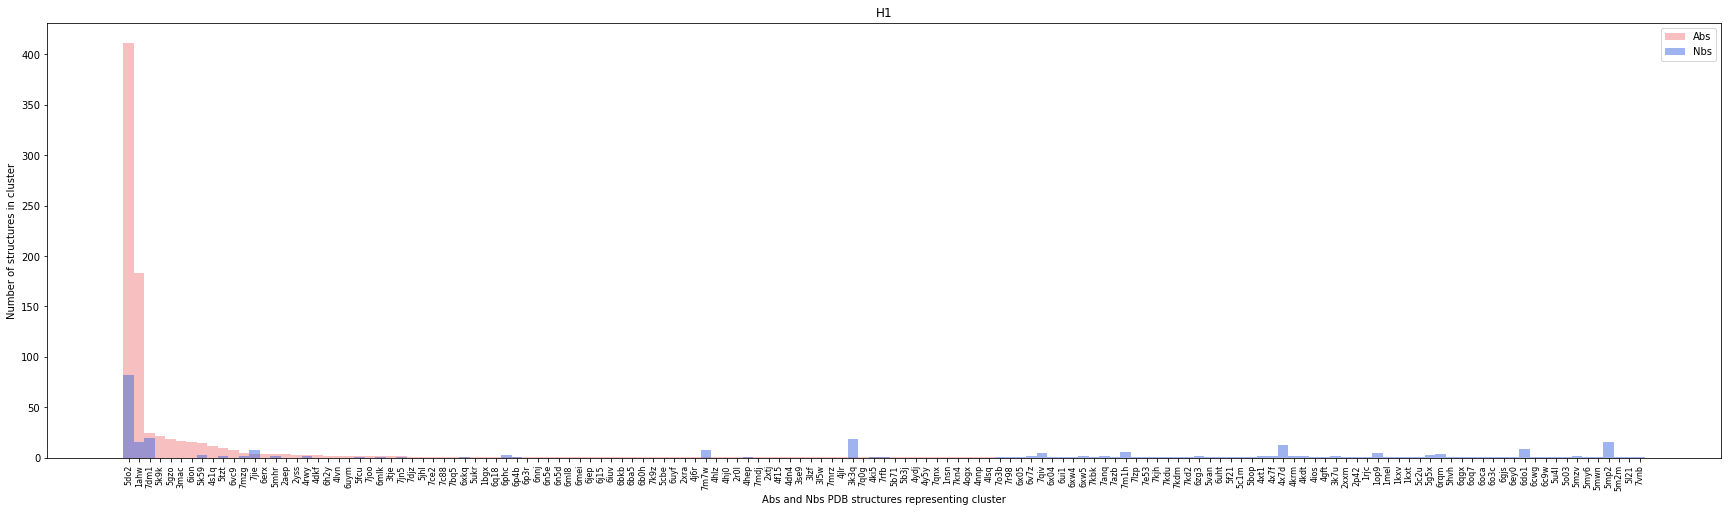

In [38]:
#### Plot index (PDBs) against frequencies of Abs and Nbs within cluster represented by that PDB 
#### H1
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30,8))
ax.bar(all_h1_freqs.index, all_h1_freqs['Abs'], label='Abs', color='lightcoral', width=1, alpha=0.5)
ax.bar(all_h1_freqs.index, all_h1_freqs['Nbs'], label='Nbs', color='royalblue', width=1, alpha=0.5)
ax.set_xticklabels(all_h1_freqs.index, rotation=90, size=8)
ax.set_title('H1')
ax.set_xlabel('Abs and Nbs PDB structures representing cluster')
ax.set_ylabel('Number of structures in cluster')
ax.legend()
plt.show()

<ipython-input-39-0a12fc7204a0>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(all_h2_freqs.index, rotation=90, size=8)


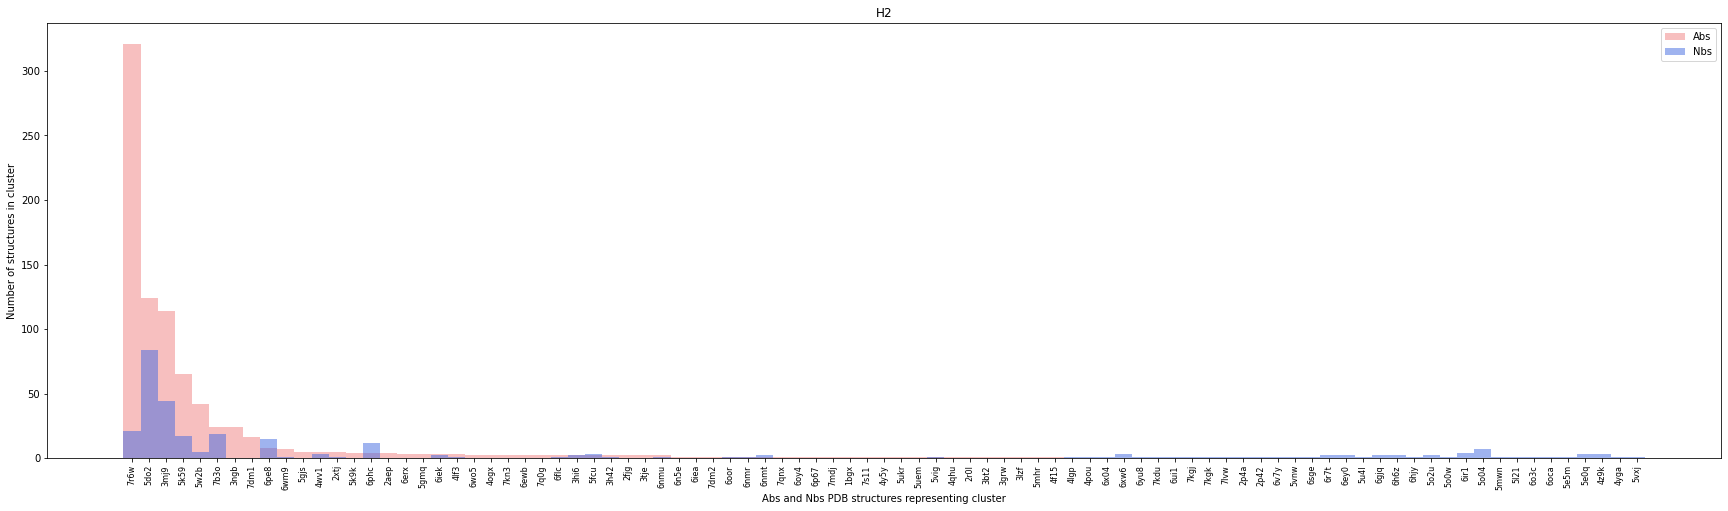

In [39]:
#### H2
fig, ax = plt.subplots(figsize=(30,8))
ax.bar(all_h2_freqs.index, all_h2_freqs['Abs'], label='Abs', color='lightcoral', width=1, alpha=0.5)
ax.bar(all_h2_freqs.index, all_h2_freqs['Nbs'], label='Nbs', color='royalblue', width=1, alpha=0.5)
ax.set_xticklabels(all_h2_freqs.index, rotation=90, size=8)
ax.set_title('H2')
ax.set_xlabel('Abs and Nbs PDB structures representing cluster')
ax.set_ylabel('Number of structures in cluster')
ax.legend()
plt.show()

<ipython-input-40-aff291707305>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(all_h3_freqs.index, rotation=90, size=2)


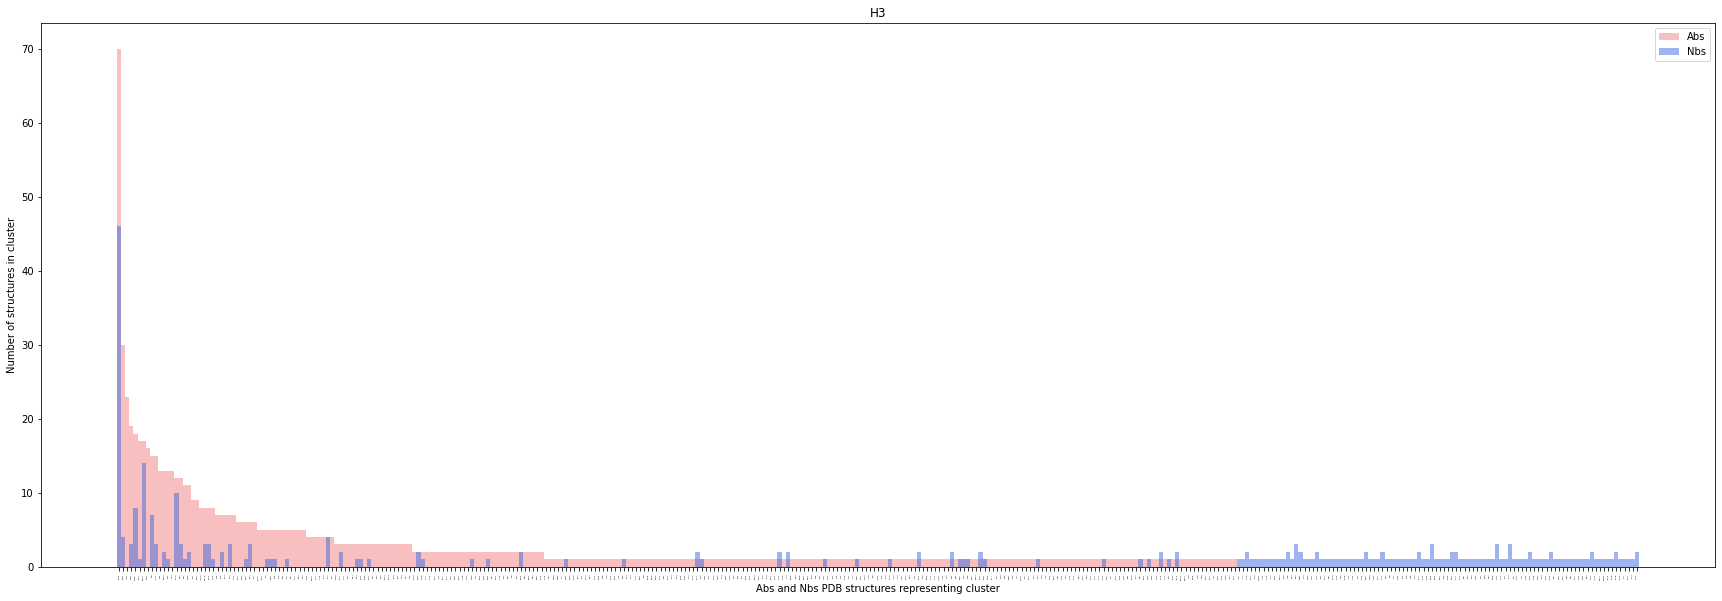

In [40]:
#### H3
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(all_h3_freqs.index, all_h3_freqs['Abs'], label='Abs', color='lightcoral', width=1, alpha=0.5)
ax.bar(all_h3_freqs.index, all_h3_freqs['Nbs'], label='Nbs', color='royalblue', width=1, alpha=0.5)
ax.set_xticklabels(all_h3_freqs.index, rotation=90, size=2)
ax.set_title('H3')
ax.set_xlabel('Abs and Nbs PDB structures representing cluster')
ax.set_ylabel('Number of structures in cluster')
ax.legend()
plt.show()


In [46]:
# all_h1_freqs = pd.read_csv('all_H1_freqs.csv')
# all_h2_freqs = pd.read_csv('all_H2_freqs.csv')
# all_h3_freqs = pd.read_csv('all_H3_freqs.csv')

#how many Abs and Nbs clusters overlap, how many clusters contain only Abs or Nbs?
print('Total:', len(all_h3_freqs))
print('Only Abs:', len(all_h3_freqs.loc[(all_h3_freqs["Abs"] != 0) & (all_h3_freqs["Nbs"] == 0)]))
print('Only Nbs:', len(all_h3_freqs.loc[(all_h3_freqs["Abs"] == 0) & (all_h3_freqs["Nbs"] != 0)]))
print('Overlap:', len(all_h3_freqs.loc[(all_h3_freqs["Abs"] != 0) & (all_h3_freqs["Nbs"] != 0)]))
#how many clusters are singletons?
print('Abs singletons:', len(all_h3_freqs.loc[(all_h3_freqs["Abs"] == 1) & (all_h3_freqs["Nbs"] == 0)]))
print('Nbs singletons:', len(all_h3_freqs.loc[(all_h3_freqs["Nbs"] == 1) & (all_h3_freqs["Abs"] == 0)]))

Total: 371
Only Abs: 215
Only Nbs: 98
Overlap: 58
Abs singletons: 146
Nbs singletons: 80
